## Univariate analysis

Additional insights can be uncovered by exploring the relationship between the target field expressed as delay rate and each feature on a univariate basis. This approach does not account for the combinatorial effect of features that will be captured by the machine learning approach. For example, the weather in port is of less importance for a ship that is sailing several thousands of kilometres from the port in question and only increases in importance when the ship approaches port. Consequently, weather becomes more predictive when considered on a multivariate basis and in combination with the “distance to port” and “current speed” features.

The features used are:
* hour of the day
* max daily temp
* month of year
* visibility
* hazardous cargo onboard
* port loading (tugs)

In [1]:
# base libraries
import numpy as np
import pandas as pd
import datetime
import math
import os
import json
import matplotlib.pyplot as plt

In [2]:
# set variable from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

processing_path = config['DEFAULT']['processing_path']
features_filename = config['DEFAULT']['features_filename']

In [3]:
features = pd.read_csv(processing_path + features_filename,header = 0,delimiter = ',')
features['dt'] = pd.to_datetime(features['dt'])

In [4]:
features = features[['MMSI','dt','tripid','delay15','HOD','MOY','max_temp','visibility','pl_type_tug','in_hazmat','out_hazmat']]

### Grouping variables

In [5]:
# hour of day
bins = [0,4,8,9,11,13,17,22,24]
groups = ['22:00 - 04:00','04:00 - 08:00','08:00 - 09:00','09:00 - 11:00','11:00 - 13:00','13:00 - 17:00','17:00 - 22:00','22:00 - 4:00']
features['time_period'] = pd.cut(features['HOD'], bins, labels=groups)
features['time_period'] = features['time_period'].str.replace('22:00 - 4:00','22:00 - 04:00')

In [6]:
# maximum daily temperature
min_temp = features['max_temp'].min()
max_temp = features['max_temp'].max()
bins = [min_temp,12,20,max_temp]
groups = ['<12','12-20','20+']
features['temp_group'] = pd.cut(features['max_temp'], bins, labels=groups)

In [7]:
# month of year
features['MOY_group'] = features['MOY'].map({1:'Nov-Jan',2:'Feb-May',3:'Feb-May',4:'Feb-May',5:'Feb-May',6:'Jun-Jul',
                                      7:'Jun-Jul',8:'Aug-Oct',9:'Aug-Oct',10:'Aug-Oct',11:'Nov-Jan',12:'Nov-Jan'})

In [8]:
# visibility
min_vis = features['visibility'].min()
max_vis = features['visibility'].max()
bins = [min_vis,9,13,20,max_vis]
groups = ['<9','9-13','13-20','20+']
features['vis_group'] = pd.cut(features['visibility'], bins, labels=groups)

### Total delays

In [9]:
# function to convert a value to the percentage of the row total
def get_pct(x):
    return(x/(x.sum()))

In [10]:
delay_total = features.drop_duplicates(subset = ['MMSI','tripid'], keep = 'first')
delay_total = delay_total.groupby('delay15')['dt'].count()
delay_total = get_pct(delay_total)

In [11]:
def create_index(df,var):
    
    df_new = df.drop_duplicates(subset = ['MMSI','tripid'], keep = 'first')
    
    df_new = df_new.groupby([var,'delay15'])['MMSI'].count()
    
    df_new = df_new/df_new.sum(level=[0])
    
    df_new = df_new[np.in1d(df_new.index.get_level_values(1), [True])]
    
    return df_new/delay_total[True]

In [12]:
def plot_univar(series_to_plot):
    colours = list()
    for i in series_to_plot:
        if i > 1:
            colours.append('red')
        else:
            colours.append('mediumseagreen')

    series_to_plot.plot(kind='bar', color = colours, linewidth=1)
    plt.axhline(y=1, color = 'black')
    return plt

### Plots
The plots below give the results of univariate analysis for a selection of notable model features giving delay rates relative to background balanced delay rate (0.5)s. Highlights include:
* Ship delays are less likely to occur in the early hours of the morning and during the late afternoon and evening 
* There is an increased likelihood of a delay occurring at the start of the working day and during the lunchtime window 
* Delays are generally more likely to occur in poorer weather conditions, this is clearly shown in both the temperature and visibility charts and specifically for temperatures below 12 degrees and visibility of less than 13 miles 
* Seasonality is also indicative of delays with ships arriving in the months of August, September and October less likely to suffer delays, with ships arriving in February, March, April and May more likely. It is suggested that seasonality may be related to weather 
* If a ship is not carrying hazardous cargo it is less likely to be delayed 
* Finally, the likelihood of being delayed increases with the number of tugs operating within the harbour. It is suggested that as many larger ships require tugs this feature is indicative of the number of ships manoeuvring into berth and therefore the availability or otherwise of suitable berths. It is likely that this feature is related to the segment based on port loading features, specifically those relating to the docked and docking segments

In [13]:
univar_hod = create_index(features,'time_period')
univar_temp = create_index(features,'temp_group')
univar_moy = create_index(features,'MOY_group')
univar_vis = create_index(features,'vis_group')
univar_in_haz = create_index(features,'in_hazmat')
univar_tug = create_index(features,'pl_type_tug')

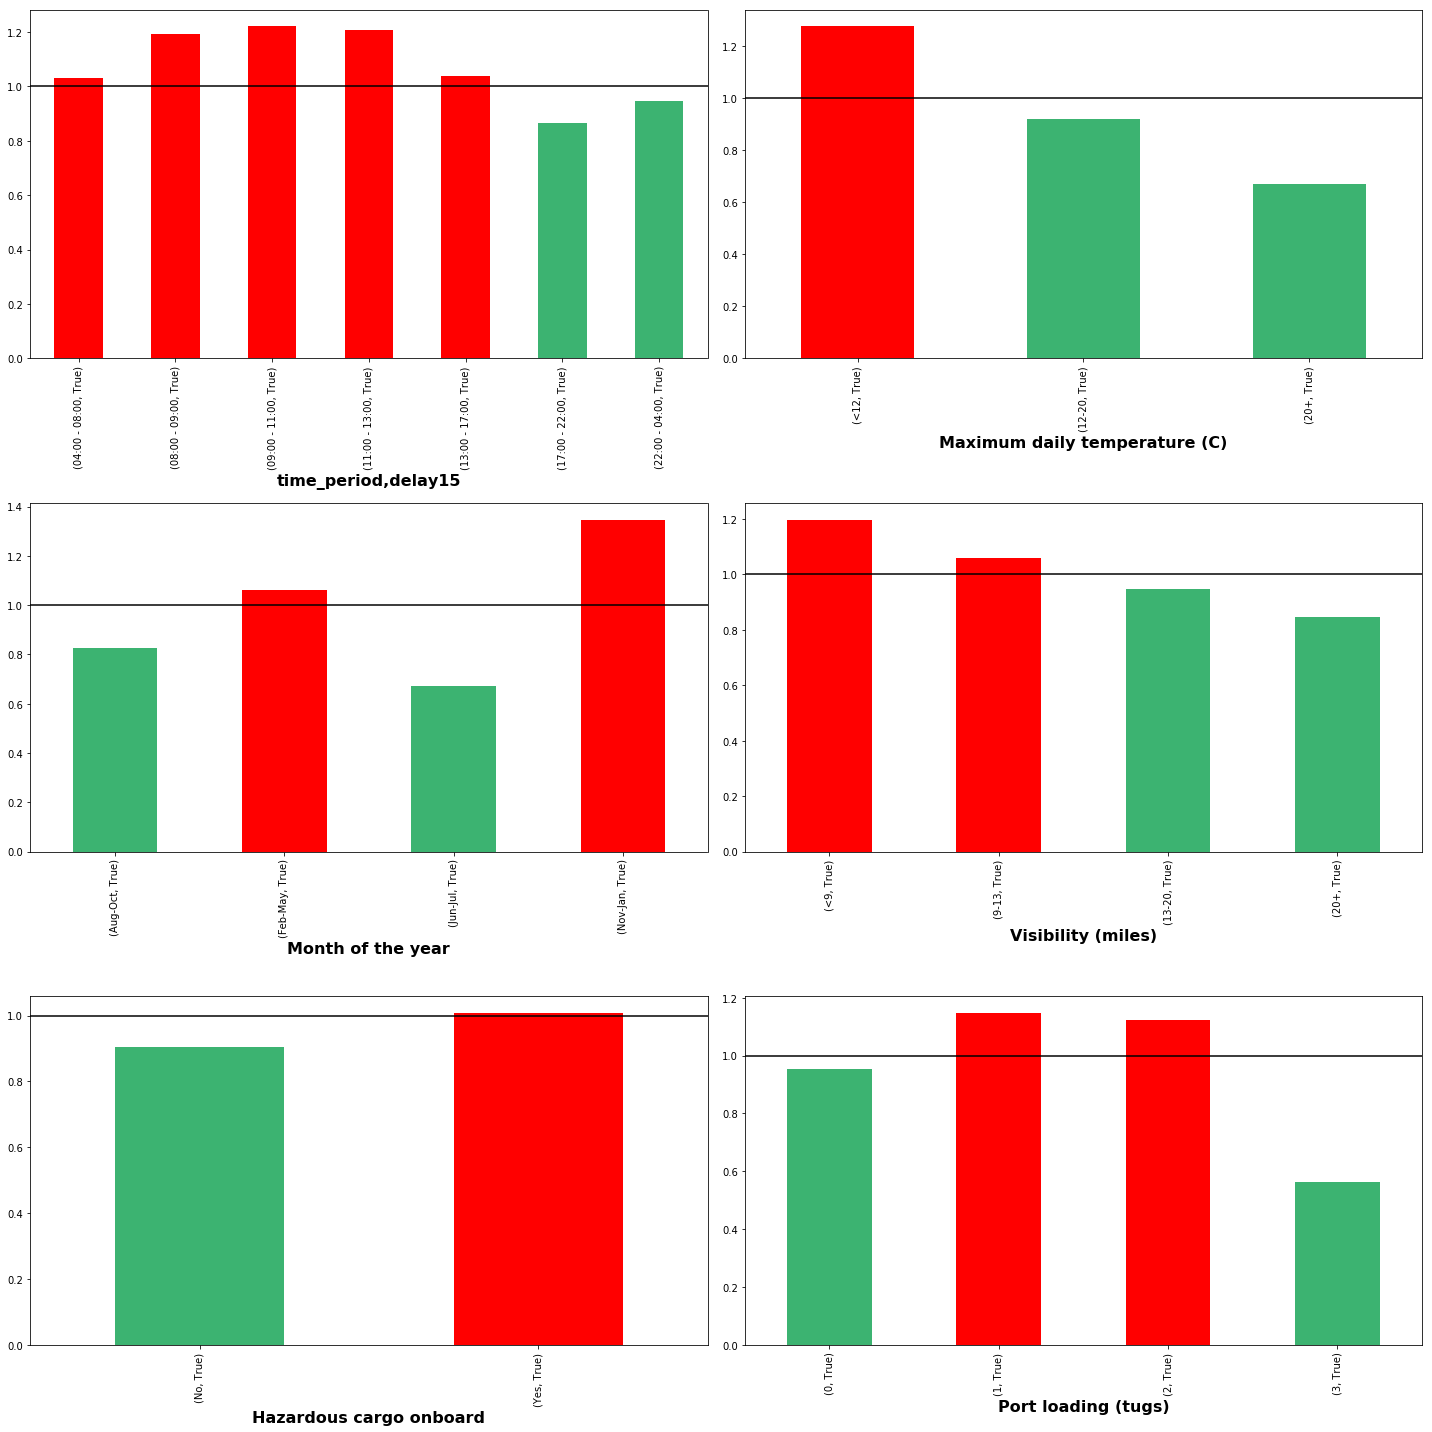

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.xlabel('Hour of day',fontsize=16, weight='bold')
plot_univar(univar_hod)
plt.subplot(322)
plot_univar(univar_temp)
plt.xlabel('Maximum daily temperature (C)',fontsize=16, weight='bold')
plt.subplot(323)
plot_univar(univar_moy)
plt.xlabel('Month of the year',fontsize=16, weight='bold')
plt.subplot(324)
plot_univar(univar_vis)
plt.xlabel('Visibility (miles)',fontsize=16, weight='bold')
plt.subplot(325)
plot_univar(univar_in_haz)
plt.xlabel('Hazardous cargo onboard',fontsize=16, weight='bold')
plt.subplot(326)
plot_univar(univar_tug)
plt.xlabel('Port loading (tugs)',fontsize=16, weight='bold')
plt.tight_layout(pad=1.08)
plt.show()